# 对各个国家按照获得奖牌数和获得奖牌的稳定性进行分类

##　加载数据

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
%cd dataset
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/dataset
country.csv		       noc_codes.json		     robust_scaler.pkl
country_medal_probability.csv  olympic_medals_2000-2020.csv  scatter_matrix.png
country_olympic_potential.csv  olympic_medals_with_noc.csv   score_validation.png
data_dictionary.csv	       olympic_score_model.pkl	     summerOly_athletes.csv
final_medal_table.csv	       potential_stars.csv	     summerOly_hosts.csv
medal_distribution.png	       potential_stars_filtered.csv  summerOly_medal_counts.csv
merged_country_data.csv        residual_plot.png	     summerOly_programs.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
athletes = pd.read_csv('summerOly_athletes.csv')
hosts = pd.read_csv('summerOly_hosts.csv')
medal_counts = pd.read_csv('summerOly_medal_counts.csv')
programs = pd.read_csv('summerOly_programs.csv',encoding='latin-1')
countrys = pd.read_csv('country.csv')

In [15]:
medal_counts.info()
medal_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rank    1435 non-null   int64 
 1   NOC     1435 non-null   object
 2   Gold    1435 non-null   int64 
 3   Silver  1435 non-null   int64 
 4   Bronze  1435 non-null   int64 
 5   Total   1435 non-null   int64 
 6   Year    1435 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 78.6+ KB


,Rank,NOC,Gold,Silver,Bronze,Total,Year
0,1,United States,11,7,2,20,1896
1,2,Greece,10,18,19,47,1896
2,3,Germany,6,5,2,13,1896
3,4,France,5,4,2,11,1896
4,5,Great Britain,2,3,2,7,1896
...,...,...,...,...,...,...,...
1430,84,Qatar,0,0,1,1,2024
1431,84,Refugee Olympic Team,0,0,1,1,2024
1432,84,Singapore,0,0,1,1,2024
1433,84,Slovakia,0,0,1,1,2024


In [28]:
# prompt: 在medal_counts中获取China的各个奖牌数目的变化

# 筛选出中国的数据
china_medals = medal_counts[medal_counts['NOC'] == 'China']

china_medals

,Rank,NOC,Gold,Silver,Bronze,Total,Year
599,4,China,15,8,9,32,1984
653,11,China,5,11,12,28,1988
698,4,China,16,22,16,54,1992
762,4,China,16,22,12,50,1996
840,3,China,28,16,14,58,2000
919,2,China,32,17,14,63,2004
992,1,China,48,22,30,100,2008
1080,2,China,39,31,22,92,2012
1167,3,China,26,18,26,70,2016
1252,2,China,38,32,19,89,2020


China Medal Changes:
Gold: 599      NaN
653    -10.0
698     11.0
762      0.0
840     12.0
919      4.0
992     16.0
1080    -9.0
1167   -13.0
1252    12.0
1345     2.0
Name: Gold, dtype: float64
Silver: 599      NaN
653      3.0
698     11.0
762      0.0
840     -6.0
919      1.0
992      5.0
1080     9.0
1167   -13.0
1252    14.0
1345    -5.0
Name: Silver, dtype: float64
Bronze: 599      NaN
653      3.0
698      4.0
762     -4.0
840      2.0
919      0.0
992     16.0
1080    -8.0
1167     4.0
1252    -7.0
1345     5.0
Name: Bronze, dtype: float64
Total: 599      NaN
653     -4.0
698     26.0
762     -4.0
840      8.0
919      5.0
992     37.0
1080    -8.0
1167   -22.0
1252    19.0
1345     2.0
Name: Total, dtype: float64


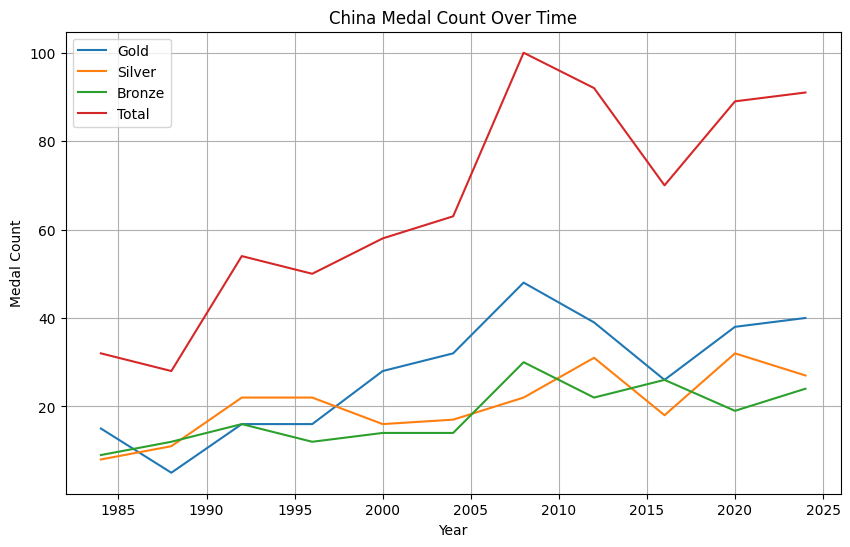

In [29]:
# 获取奖牌数目的变化
gold_changes = china_medals['Gold'].diff()
silver_changes = china_medals['Silver'].diff()
bronze_changes = china_medals['Bronze'].diff()
total_changes = china_medals['Total'].diff()

# 打印或者可视化变化
print("China Medal Changes:")
print("Gold:", gold_changes)
print("Silver:", silver_changes)
print("Bronze:", bronze_changes)
print("Total:", total_changes)


# 可视化
plt.figure(figsize=(10, 6))
plt.plot(china_medals['Year'], china_medals['Gold'], label='Gold')
plt.plot(china_medals['Year'], china_medals['Silver'], label='Silver')
plt.plot(china_medals['Year'], china_medals['Bronze'], label='Bronze')
plt.plot(china_medals['Year'], china_medals['Total'], label='Total')

plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.title('China Medal Count Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# 假设原始数据存储在变量df中
df = medal_counts.copy()

# 删除Year在1984年之前的数据
df = df[df['Year'] >= 1984]

# 按国家统计各奖牌的总和
sum_df = df.groupby('NOC').agg(
    Gold_sum=('Gold', 'sum'),
    Silver_sum=('Silver', 'sum'),
    Bronze_sum=('Bronze', 'sum'),
    Total_sum=('Total', 'sum')
).reset_index()

# 假设原始数据存储在 df 中（包含 Year 和 Total 列）
# 计算每个国家每年的奖牌数（若未预聚合）
# 按国家分组计算变异系数（CV）
cv_df = df.groupby("NOC")["Total"].apply(
    lambda x: x.std() / x.mean() if x.mean() != 0 else 0  # 处理均值为0的情况
).reset_index(name="CV")

# 合并总奖牌数和CV到结果中
result = pd.merge(sum_df, cv_df, on="NOC")

# 定义分类规则（基于中位数）
total_median = result["Total_sum"].median()
cv_median = result["CV"].median()

def classify(row):
    if row["Total_sum"] >= total_median and row["CV"] <= cv_median:
        return "奖牌多且稳定"
    elif row["Total_sum"] < total_median and row["CV"] <= cv_median:
        return "奖牌少但稳定"
    elif row["Total_sum"] >= total_median and row["CV"] > cv_median:
        return "奖牌多但不稳定"
    else:
        return "奖牌少且不稳定"

result["Category"] = result.apply(classify, axis=1)
result.to_csv("classified_country_medal_stats_cv.csv", index=False)

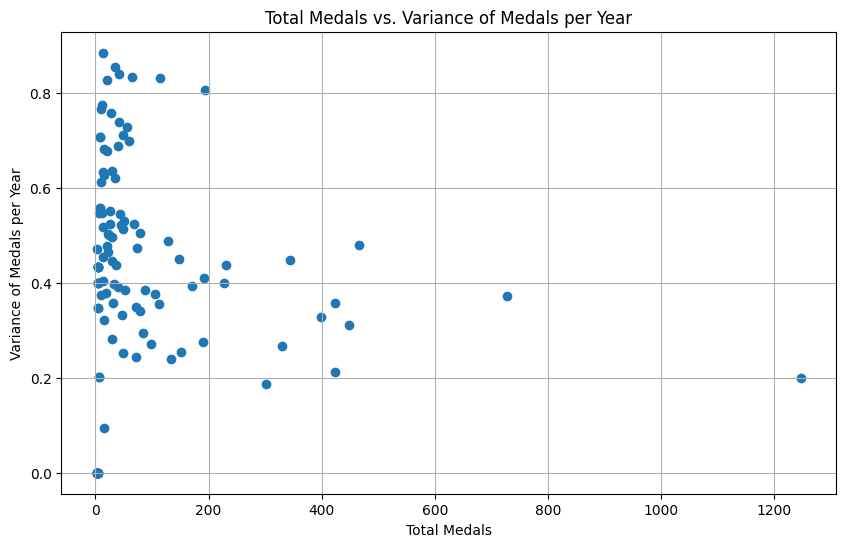

In [38]:
# 将result按照Total_sum列和Variance分别作为横纵坐标作图

import matplotlib.pyplot as plt

# Assuming 'result' DataFrame is already created as in the previous code

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(result['Total_sum'], result['CV'])
plt.xlabel('Total Medals')
plt.ylabel('Variance of Medals per Year')
plt.title('Total Medals vs. Variance of Medals per Year')
plt.grid(True)
plt.show()

In [40]:
# 计算中位数
total_median = result['Total_sum'].median()
variance_median = result['CV'].median()

# 处理可能的NaN方差（如单年数据导致方差为NaN）
result['CV'] = result['CV'].fillna(variance_median)  # 将NaN视为中等方差

# 分类函数
def classify(row):
    if row['Total_sum'] >= total_median and row['CV'] <= variance_median:
        return '奖牌多且稳定'
    elif row['Total_sum'] < total_median and row['CV'] <= variance_median:
        return '奖牌少但稳定'
    elif row['Total_sum'] >= total_median and row['CV'] > variance_median:
        return '奖牌多但不稳定'
    else:
        return '奖牌少且不稳定'

# 添加分类列
result['Category'] = result.apply(classify, axis=1)

# 保存结果到新文件
result.to_csv('classified_country_medal_stats_after1984_useCV.csv', index=False)

# 显示分类统计
print(result['Category'].value_counts())

Category
奖牌少但稳定     55
奖牌多但不稳定    39
奖牌多且稳定     37
奖牌少且不稳定    18
Name: count, dtype: int64
